In [1]:
# Initial Setup.
import pandas as pd
import re
import numpy as np
import math
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Mastodon_SaiGinny/'

pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)


Mounted at /content/gdrive


In [18]:
import pandas as pd

data_matched=pd.read_csv(path+'finally_matched.csv')


data_matched['is_multi'] = data_matched['discipline'].str.contains(',')

data_matched.loc[data_matched['is_multi'], 'discipline'] = 'multi-disciplinary'

unique_acct_count = data_matched.groupby('discipline')['acct'].nunique().reset_index()
data_matched['last_status_at'] = pd.to_datetime(data_matched['last_status_at'])
disciplines = data_matched['discipline'].unique()
columns = ['discipline', 'total', 'One_Time', 'One_Time_percent', 'Short_Term', 'Short_Term_percent', 'Long_Term', 'Long_Term_percent', 'Persistent', 'Persistent_percent']
discipline_count = pd.DataFrame(columns=columns)

for discipline in disciplines:
    temp = data_matched[data_matched['discipline'] == discipline]

    total = temp['acct'].nunique()

    user_diffs = temp.groupby('acct').apply(lambda x: (x['last_status_at'].max() - x['last_status_at'].min()).days)
    temp = temp.join(user_diffs.rename('user_diffs'), on='acct')

    One_Time = temp[temp['user_diffs'] <= 7]['acct'].nunique()
    Short_Term = temp[(temp['user_diffs'] > 7) & (temp['user_diffs'] <= 100)]['acct'].nunique()
    Long_Term = temp[(temp['user_diffs'] > 100) & (temp['user_diffs'] <= 300)]['acct'].nunique()
    Persistent = temp[temp['user_diffs'] > 300]['acct'].nunique()

    new_row = pd.DataFrame({
        'discipline': [discipline],
        'total': [total],
        'One_Time': [One_Time],
        'One_Time_percent': [One_Time / total if total > 0 else 0],
        'Short_Term': [Short_Term],
        'Short_Term_percent': [Short_Term / total if total > 0 else 0],
        'Long_Term': [Long_Term],
        'Long_Term_percent': [Long_Term / total if total > 0 else 0],
        'Persistent': [Persistent],
        'Persistent_percent': [Persistent / total if total > 0 else 0],
    })

    discipline_count = pd.concat([discipline_count, new_row], ignore_index=True)

discipline_count


<ipython-input-18-b93efb0bf4ce>:3: DtypeWarning: Columns (26,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data_matched=pd.read_csv(path+'finally_matched.csv')


,discipline,total,One_Time,One_Time_percent,Short_Term,Short_Term_percent,Long_Term,Long_Term_percent,Persistent,Persistent_percent
0,Anthropologists,50,7,0.140000,9,0.180000,10,0.200000,24,0.480000
1,multi-disciplinary,961,107,0.111342,184,0.191467,284,0.295525,386,0.401665
2,Archaeologists,126,19,0.150794,23,0.182540,34,0.269841,50,0.396825
3,Art and Design Teachers,8,1,0.125000,0,0.000000,2,0.250000,5,0.625000
4,Asianists,26,6,0.230769,7,0.269231,5,0.192308,8,0.307692
5,Astrophysicists,53,2,0.037736,6,0.113208,14,0.264151,31,0.584906
6,Atmospheric and air quality,41,8,0.195122,13,0.317073,7,0.170732,13,0.317073
7,Biblical Studies,4,1,0.250000,0,0.000000,1,0.250000,2,0.500000
8,Bioinformaticians,13,0,0.000000,4,0.307692,6,0.461538,3,0.230769
9,Biophysicists,8,0,0.000000,1,0.125000,3,0.375000,4,0.500000


In [30]:
import pandas as pd


field_mapping = {
    "Anthropologists": "Social and Behavioral Sciences",
    "Archaeologists": "Arts and Humanities",
    "Art and Design Teachers": "Arts and Humanities",
    "Asianists": "Social and Behavioral Sciences",
    "Astrophysicists": "Physical Sciences and Mathematics",
    "Atmospheric and air quality": "Physical Sciences and Mathematics",
    "Biblical Studies": "Arts and Humanities",
    "Bioinformaticians": "Life Sciences",
    "Biophysicists": "Life Sciences",
    "BookHistorians": "Arts and Humanities",
    "ChemCommunity": "Physical Sciences and Mathematics",
    "Cheminformaticians and Computational Chemists": "Physical Sciences and Mathematics",
    "Communication and Media Studies": "Social and Behavioral Sciences",
    "Criminology": "Social and Behavioral Sciences",
    "Dendrochronology": "Physical Sciences and Mathematics",
    "Digital humanties": "Arts and Humanities",
    "Educators": "Education",
    "Geneology": "Social and Behavioral Sciences",
    "Geographers": "Social and Behavioral Sciences",
    "Geology": "Physical Sciences and Mathematics",
    "Glams": "Arts and Humanities",
    "Historian": "Arts and Humanities",
    "History and philosophy of science": "Arts and Humanities",
    "Information security": "Physical Sciences and Mathematics",
    "Iran and middle eastern studies": "Social and Behavioral Sciences",
    "Journalists": "Social and Behavioral Sciences",
    "Law": "Law",
    "Linguistics": "Social and Behavioral Sciences",
    "LitStudies": "Arts and Humanities",
    "Marketing": "Business",
    "MedicalAI": "Medicine and Health Sciences",
    "Medieval studies": "Arts and Humanities",
    "Meteorology": "Physical Sciences and Mathematics",
    "Neuroscience": "Medicine and Health Sciences",
    "Nuclear fusion": "Physical Sciences and Mathematics",
    "Open science": "Multi-disciplinary",
    "Palaeogenomics": "Life Sciences",
    "Philosophy": "Arts and Humanities",
    "Plant Science": "Life Sciences",
    "Political science": "Social and Behavioral Sciences",
    "Psychology": "Social and Behavioral Sciences",
    "Public policy": "Social and Behavioral Sciences",
    "Qualitative Researchers": "Social and Behavioral Sciences",
    "Religion": "Arts and Humanities",
    "Science and technology studies": "Social and Behavioral Sciences",
    "SemanticWeb": "Social and Behavioral Sciences",
    "Sociology": "Social and Behavioral Sciences",
    "TechPolicy": "Social and Behavioral Sciences",
    "Theology": "Arts and Humanities",
    "multi-disciplinary": "Multi-disciplinary"
}


data_matched['field'] = data_matched['discipline'].map(field_mapping)




In [46]:
fields = data_matched['field'].unique()
columns = ['field', 'total', 'One_Time', 'One_Time_percent', 'Short_Term', 'Short_Term_percent', 'Long_Term', 'Long_Term_percent', 'Persistent', 'Persistent_percent']
fields_count = pd.DataFrame(columns=columns)

for field in fields:
    temp = data_matched[data_matched['field'] == field]

    total = temp['acct'].nunique()

    user_diffs = temp.groupby('acct').apply(lambda x: (x['last_status_at'].max() - x['last_status_at'].min()).days)
    temp = temp.join(user_diffs.rename('user_diffs'), on='acct')

    One_Time = temp[temp['user_diffs'] <= 7]['acct'].nunique()
    Short_Term = temp[(temp['user_diffs'] > 7) & (temp['user_diffs'] <= 100)]['acct'].nunique()
    Long_Term = temp[(temp['user_diffs'] > 100) & (temp['user_diffs'] <= 300)]['acct'].nunique()
    Persistent = temp[temp['user_diffs'] > 300]['acct'].nunique()

    new_row = pd.DataFrame({
        'field': [field],
        'total': [total],
        'One_Time': [One_Time],
        'One_Time_percent': [One_Time / total if total > 0 else 0],
        'Short_Term': [Short_Term],
        'Short_Term_percent': [Short_Term / total if total > 0 else 0],
        'Long_Term': [Long_Term],
        'Long_Term_percent': [Long_Term / total if total > 0 else 0],
        'Persistent': [Persistent],
        'Persistent_percent': [Persistent / total if total > 0 else 0],
    })

    fields_count = pd.concat([fields_count, new_row], ignore_index=True)

fields_count

,field,total,One_Time,One_Time_percent,Short_Term,Short_Term_percent,Long_Term,Long_Term_percent,Persistent,Persistent_percent
0,Social and Behavioral Sciences,2918,459,0.157300,624,0.213845,815,0.279301,1020,0.349554
1,Arts and Humanities,1522,312,0.204993,295,0.193824,378,0.248357,537,0.352825
2,Physical Sciences and Mathematics,851,102,0.119859,180,0.211516,237,0.278496,332,0.390129
3,Life Sciences,84,9,0.107143,17,0.202381,35,0.416667,23,0.273810
4,Education,244,52,0.213115,64,0.262295,59,0.241803,69,0.282787
5,Law,587,105,0.178876,166,0.282794,156,0.265758,160,0.272572
6,Business,4,1,0.250000,1,0.250000,1,0.250000,1,0.250000
7,Medicine and Health Sciences,287,31,0.108014,87,0.303136,84,0.292683,85,0.296167
8,Multi-disciplinary,1040,112,0.107692,190,0.182692,300,0.288462,438,0.421154


In [47]:
multi_disciplinary_row = fields_count[fields_count['field'] == 'Multi-disciplinary']
fields_count = fields_count[fields_count['field'] != 'Multi-disciplinary']
fields_count = pd.concat([fields_count, multi_disciplinary_row], ignore_index=True)

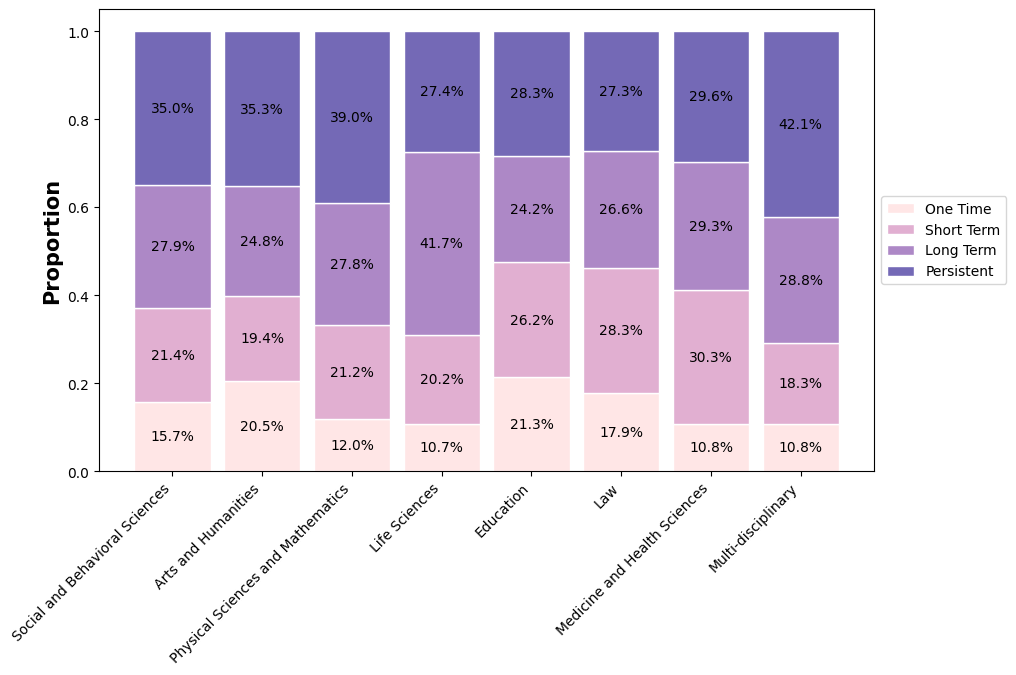

In [48]:
fields_count_filtered = {k: [v[i] for i in range(len(fields_count['field'])) if fields_count['field'][i] != 'Business'] for k, v in fields_count.items()}

fields = fields_count_filtered['field']
one_time = fields_count_filtered['One_Time_percent']
short_term = fields_count_filtered['Short_Term_percent']
long_term = fields_count_filtered['Long_Term_percent']
persistent = fields_count_filtered['Persistent_percent']

barWidth = 0.85


colors = ['#FFE6E6', '#E1AFD1', '#AD88C6', '#7469B6']


plt.figure(figsize=(10, 6))


p1 = plt.bar(fields, one_time, color=colors[0], edgecolor='white', width=barWidth)
p2 = plt.bar(fields, short_term, bottom=one_time, color=colors[1], edgecolor='white', width=barWidth)
p3 = plt.bar(fields, long_term, bottom=[i+j for i,j in zip(one_time, short_term)], color=colors[2], edgecolor='white', width=barWidth)
p4 = plt.bar(fields, persistent, bottom=[i+j+k for i,j,k in zip(one_time, short_term, long_term)], color=colors[3], edgecolor='white', width=barWidth)


plt.ylabel('Proportion', fontweight='bold', fontsize=15)
plt.xticks(rotation=45, ha='right')

for i in range(len(fields)):
    plt.text(i, one_time[i] / 2, f"{one_time[i]*100:.1f}%", ha='center', va='center', color='black', fontsize=10)
    plt.text(i, one_time[i] + short_term[i] / 2, f"{short_term[i]*100:.1f}%", ha='center', va='center', color='black', fontsize=10)
    plt.text(i, one_time[i] + short_term[i] + long_term[i] / 2, f"{long_term[i]*100:.1f}%", ha='center', va='center', color='black', fontsize=10)
    plt.text(i, one_time[i] + short_term[i] + long_term[i] + persistent[i] / 2, f"{persistent[i]*100:.1f}%", ha='center', va='center', color='black', fontsize=10)

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('One Time', 'Short Term', 'Long Term', 'Persistent'),
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

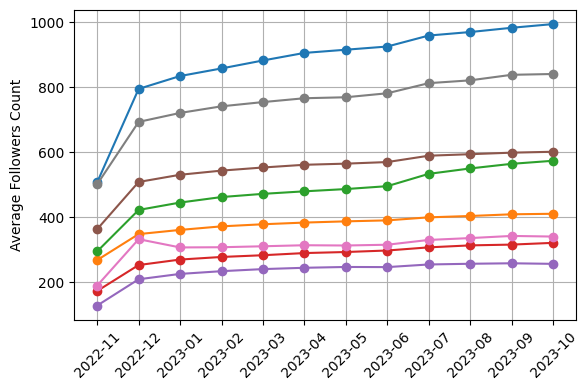

In [57]:
plt.figure(figsize=(6, 4))
data_matched['directory'] = pd.to_datetime(data_matched['directory'])

data_matched['year_month'] = data_matched['directory'].dt.to_period('M')
for field in fields:
  data_matched_field = data_matched[data_matched['field'] == field]
  monthly_max_followers = data_matched_field.groupby(['acct', 'year_month'])['followers_count'].max().reset_index()

  monthly_avg_max_followers = monthly_max_followers.groupby('year_month')['followers_count'].mean().reset_index()


  plt.plot(monthly_avg_max_followers['year_month'].astype(str), monthly_avg_max_followers['followers_count'], marker='o', label=field)
#plt.xlabel('Month')
plt.ylabel('Average Followers Count')
#plt.title('Average Maximum Followers Count per Month')
plt.xticks(rotation=45)
plt.grid(True)
#plt.legend(title='Legend')
plt.tight_layout()
plt.show()


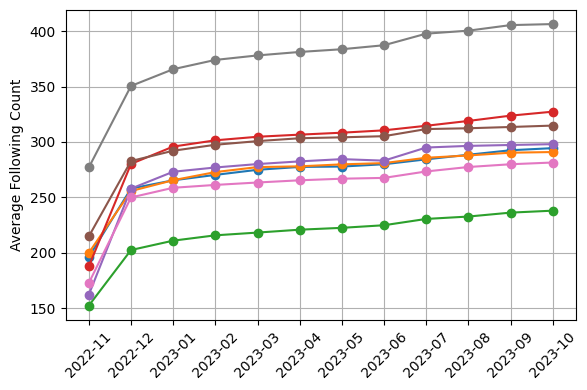

In [58]:
plt.figure(figsize=(6, 4))
data_matched['directory'] = pd.to_datetime(data_matched['directory'])

data_matched['year_month'] = data_matched['directory'].dt.to_period('M')
for field in fields:
  data_matched_field = data_matched[data_matched['field'] == field]
  monthly_max_followers = data_matched_field.groupby(['acct', 'year_month'])['following_count'].max().reset_index()

  monthly_avg_max_followers = monthly_max_followers.groupby('year_month')['following_count'].mean().reset_index()


  plt.plot(monthly_avg_max_followers['year_month'].astype(str), monthly_avg_max_followers['following_count'], marker='o', label=field)
#plt.xlabel('Month')
plt.ylabel('Average Following Count')
#plt.title('Average Maximum Followers Count per Month')
plt.xticks(rotation=45)
plt.grid(True)
#plt.legend(title='Legend')
plt.tight_layout()
plt.show()

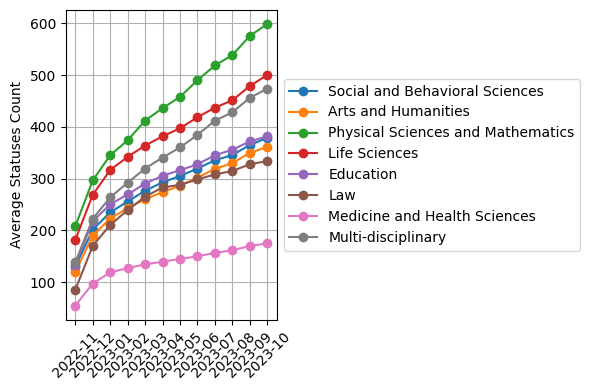

In [61]:
plt.figure(figsize=(6, 4))
data_matched['directory'] = pd.to_datetime(data_matched['directory'])

data_matched['year_month'] = data_matched['directory'].dt.to_period('M')
for field in fields:
  data_matched_field = data_matched[data_matched['field'] == field]
  monthly_max_followers = data_matched_field.groupby(['acct', 'year_month'])['statuses_count'].max().reset_index()

  monthly_avg_max_followers = monthly_max_followers.groupby('year_month')['statuses_count'].mean().reset_index()


  plt.plot(monthly_avg_max_followers['year_month'].astype(str), monthly_avg_max_followers['statuses_count'], marker='o', label=field)
#plt.xlabel('Month')
plt.ylabel('Average Statuses Count')
#plt.title('Average Maximum Followers Count per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()